In [1]:
%load_ext autoreload
%autoreload 2

In [364]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2

from htools import *
from img_wang.data import MixupDS, load_img, get_mixup_databunch
from incendio.callbacks import TorchCallback, MetricHistory
from incendio.core import Trainer
from incendio.layers import ConvBlock, ResBlock, mish, Mish

In [3]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [4]:
dir_u = Path('data/imagewang-160/unsup/')

In [30]:
bs = 2
dst, dsv, dlt, dlv = get_mixup_databunch(dir_u, bs=bs)

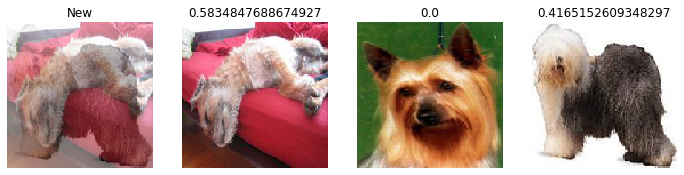

In [31]:
*imgs, w = dst[0]
show_images(imgs, figsize=(12, 4), titles=['New']+w.tolist())
plt.show()

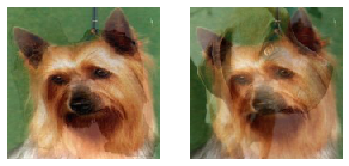

In [7]:
*xb, yb = next(iter(dlt))
show_images(xb[0])

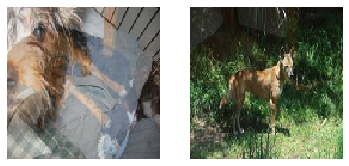

In [8]:
dst.shuffle()
*xb, yb = next(iter(dlt))
show_images(xb[0])

In [9]:
xb[0].shape

torch.Size([2, 3, 128, 128])

In [10]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

In [11]:
len(xb)

4

In [12]:
conv = nn.Conv2d(3, 5, 3)
fc = nn.AdaptiveAvgPool2d(1)
tmp = conv(xb[0])
tmp.shape

torch.Size([2, 5, 126, 126])

In [13]:
fc(tmp).squeeze().shape

torch.Size([2, 5])

torch.Size([8, 3, 128, 128])


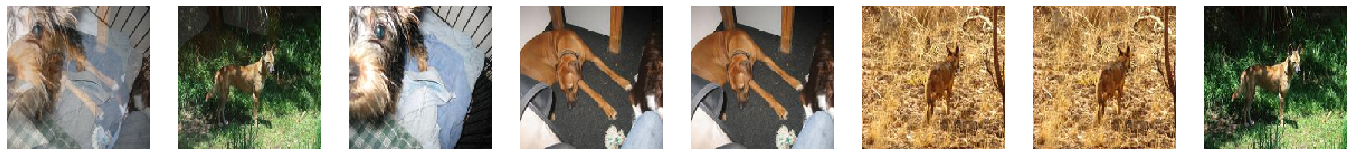

In [14]:
stk = torch.cat(xb, dim=0)
print(stk.shape)
show_images(stk)

In [15]:
tmp = conv(stk)
tmp.shape

torch.Size([8, 5, 126, 126])

In [16]:
bs = 2
shape = tmp.shape
tmp.view(bs, shape[1]*shape[0]//bs, *shape[-2:]).shape

torch.Size([2, 20, 126, 126])

In [39]:
class UnmixerModel(nn.Module):
    
    def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
                 padding=0, act=Mish(), res_blocks=0, temperature=1, 
                 **res_kwargs):
        super().__init__()
        if len(fs) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
                        activation=act, stride=stride, padding=padding) 
              for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
        )
        if res_blocks:
            self.res = nn.Sequential(*[ResBlock(c_in=fs[-1], **res_kwargs) 
                                       for _ in range(res_blocks)])
        self.pool = AdaptiveConcatPool2d(1)
        self.temp = temperature

    def forward(self, *xb):
        bs = xb[0].shape[0]
        # Stack along batch dimension so all images can be processed at once.
        xb = torch.cat(xb, dim=0)                    # (bs*(n+1), c, h, w)
        xb = self.conv(xb)                           # (bs*(n+1), f[-1], h, w)
        if hasattr(self, 'res'): xb = self.res(xb)   # No change in dims.
        xb = self.pool(xb).squeeze()                 # (bs*(n+1), emb_dim))
        xb = xb.view(bs, -1, xb.shape[-1])           # (bs, n+1, emb_dim)
        x_new, x_src = xb[:, 0, :], xb[:, 1:, :]
        xb = (x_new.unsqueeze(1) * x_src).sum(-1)    # (bs, n)
        return F.softmax(xb/self.temp, dim=-1)

In [418]:
AdaptiveConcatPool2d(1)(torch.randn(2, 3, 4, 4)).shape

torch.Size([2, 6, 1, 1])

In [342]:
# Troubleshooting UnmixerModel. Take simpler approach by just encoding each x image separately.
# Trying to figure out if my batching strategy is causing the failure to learn.
class Encoder(nn.Module):
    
    def __init__(self, n=3, c_in=3, fs=(8, 16, 32, 64, 128, 256), 
                 strides=(2, 2, 1, 1, 1, 1), kernel_size=3, norm=True, 
                 padding=0, act=Mish(), res_blocks=0, temperature=1, 
                 **res_kwargs):
        super().__init__()
        if len(fs) != len(strides):
            raise ValueError('Strides and f_dims must be same length (1 '
                             ' value for each conv block).')
            
        self.n = n
        self.conv = nn.Sequential(
            *[ConvBlock(f_in, f_out, kernel_size=kernel_size, norm=norm,
                        activation=act, stride=stride, padding=padding) 
              for f_in, f_out, stride in zip((c_in, *fs), fs, strides)]
        )
        if res_blocks:
            self.res = nn.Sequential(
                *[ResBlock(c_in=fs[-1], activation=act, **res_kwargs) 
                  for _ in range(res_blocks)]
            )
        self.pool = AdaptiveConcatPool2d(1)
        self.temp = temperature

    def _forward(self, x):
        x = self.conv(x)                             # (bs*(n+1), f[-1], h, w)
        if hasattr(self, 'res'): x = self.res(x)     # No change in dims.
        return self.pool(x).squeeze(-1).squeeze(-1)  # (bs*(n+1), emb_dim))
    
    def forward(self, *xb):
        x_new, *x = [self._forward(x) for x in xb]
        x = torch.stack(x, dim=1)
        print('forward', x_new.shape, x.shape)
        x = (x_new.unsqueeze(1) * x).sum(-1)
        return F.softmax(x/self.temp, dim=-1)

In [402]:
tmp[:, None:, :1, :1].shape

torch.Size([2, 1280, 1, 1])

In [419]:
class Unmixer(nn.Module):
    
    def __init__(self, encoder, temperature):
        super().__init__()
        self.encoder = encoder
        self.pool = AdaptiveConcatPool2d(1)
        self.temp = temperature
        
    def forward(self, *x):
        x_new, *x = [self.pool(self.encoder(x)).squeeze(-1).squeeze(-1)
                     for x in xb]
        x = torch.stack(x, dim=1)
        print('stacked shape', x.shape)
        x = (x_new[:, None, ...] * x).sum(-1)
        print('after sum', x.shape)
        return F.softmax(x/self.temp, dim=-1)

In [341]:
xb[0][None, ..., None].squeeze(0).squeeze(-1).shape

torch.Size([2, 3, 128, 128])

In [210]:
enet = Encoder(fs=[16, 64], strides=[2, 1], res_blocks=2, temperature=64)
enet

Encoder(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
  )
  (res): Sequential(
    (0): ResBlock(
      (layers): ModuleList(
        (0): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [211]:
res = enet(*xb)

In [212]:
res.shape

torch.Size([2, 3])

In [213]:
res

tensor([[5.9190e-01, 3.8113e-01, 2.6965e-02],
        [2.5858e-04, 8.8602e-05, 9.9965e-01]], grad_fn=<SoftmaxBackward>)

In [178]:
%%timeit -n 25 -r 25
(res[0].unsqueeze(1) * res[1]).sum(-1)

The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
34.3 µs ± 16.8 µs per loop (mean ± std. dev. of 25 runs, 25 loops each)


In [179]:
%%timeit -n 25 -r 25
torch.bmm(res[0].unsqueeze(1), res[1].permute(0, 2, 1))

The slowest run took 42.03 times longer than the fastest. This could mean that an intermediate result is being cached.
68.6 µs ± 183 µs per loop (mean ± std. dev. of 25 runs, 25 loops each)


In [151]:
res[1].shape

torch.Size([2, 3, 512])

In [ ]:
(b×n×m) tensor, mat2 is a (b×m×p) tensor, out will be a(b×n×p) tensor.

In [80]:
net = UnmixerModel()
net

UnmixerModel(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [41]:
# # (bs, n+1, enc_dim)
# xn, xs = net(*xb)
# xn.shape, xs.shape

res = net(*xb)
res.shape

torch.Size([2, 3])

In [42]:
res

tensor([[0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000]], grad_fn=<SoftmaxBackward>)

In [43]:
resnet = UnmixerModel(res_blocks=3)
resnet

UnmixerModel(
  (conv): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
    )
    (3): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [44]:
res = resnet(*xb)

In [45]:
res

tensor([[1.0000e+00, 5.3775e-37, 0.0000e+00],
        [5.0000e-01, 5.0000e-01, 0.0000e+00]], grad_fn=<SoftmaxBackward>)

In [120]:
yb

tensor([[0.5806, 0.4194, 0.0000],
        [0.1453, 0.0000, 0.8547]], dtype=torch.float64)

In [128]:
F.mse_loss(res, yb, reduction='sum')

tensor(1.4579, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [130]:
(res - yb).pow(2).mean(1).sum(), (res - yb).pow(2).mean(1).mean(), (res - yb).pow(2).mean()

(tensor(0.4860, dtype=torch.float64, grad_fn=<SumBackward0>),
 tensor(0.2430, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2430, dtype=torch.float64, grad_fn=<MeanBackward0>))

In [46]:
class DatasetMixer(TorchCallback):
    
    def __init__(self, order=100):
        self.order = order
    
    def on_epoch_begin(self, trainer, epoch, val_stats):
        trainer.dl_train.dataset.shuffle()

## Test Tiny Trainer

In [430]:
paths_tiny = get_image_files(dir_u)[:12]
tdst, tdsv, tdlt, tdlv = get_mixup_databunch(paths=paths_tiny, train_pct=.5, 
                                             bs=2)
len(tdst), len(tdsv)

(4, 4)

In [431]:
for i, b in enumerate(tdlt):
    print(amap('shape', *b))

[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3])]
[torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3, 128, 128]), torch.Size([2, 3])]


[torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), torch.Size([3, 128, 128])]


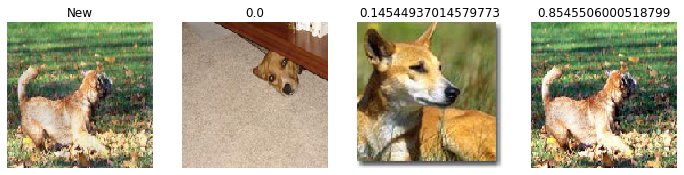

In [429]:
for i in range(len(tdst)):
    *x, y = tdst[i]
    print(amap('shape', *x))
    show_images(x, titles=['New']+y.tolist())

In [366]:
mnet = mobilenet_v2(pretrained=True)
mnet

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/hmamin/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [422]:
mnet_unmix(*xb)

stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


tensor([[0., 1., 0.],
        [0., 0., 1.]], grad_fn=<SoftmaxBackward>)

In [386]:
enet(*xb)

forward torch.Size([2, 512]) torch.Size([2, 3, 512])


tensor([[1.0000e+00, 0.0000e+00, 5.1504e-30],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], grad_fn=<SoftmaxBackward>)

In [433]:
mnet_enc = dict(mnet.named_children())['features']
mnet_unmix = Unmixer(mnet_enc, 1)

In [434]:
enet = Encoder(fs=(16, 64, 256), strides=(2, 1, 1))

In [435]:
T = Trainer(mnet_unmix, tdst, tdsv, tdlt, tdlv, F.mse_loss, mode='regression',
            out_dir='data/models/v0', 
            callbacks=[DatasetMixer(), MetricHistory()])


2020-08-08 21:16:33,157
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 1e-09
    weight_decay: 0
)


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:36,429
 
=====

Epoch 0

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4112 |       0.3219 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:41,031
 
=====

Epoch 1

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2528 |       0.2792 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:45,079
 
=====

Epoch 2

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1764 |       0.3317 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:48,733
 
=====

Epoch 3

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.5045 |       0.2180 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:52,868
 
=====

Epoch 4

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3660 |       0.4233 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:55,900
 
=====

Epoch 5

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4492 |       0.3323 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:16:58,899
 
=====

Epoch 6

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3858 |       0.2476 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:01,823
 
=====

Epoch 7

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2780 |       0.2143 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:04,540
 
=====

Epoch 8

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1826 |       0.1086 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:07,471
 
=====

Epoch 9

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4172 |       0.2971 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:10,531
 
=====

Epoch 10

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1078 |       0.2719 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:13,940
 
=====

Epoch 11

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2712 |       0.1181 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:17,123
 
=====

Epoch 12

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3543 |       0.2670 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:20,236
 
=====

Epoch 13

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.1975 |       0.3253 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:23,035
 
=====

Epoch 14

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.4825 |       0.2210 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:25,778
 
=====

Epoch 15

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3298 |       0.2773 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:29,462
 
=====

Epoch 16

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3128 |       0.1842 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:34,166
 
=====

Epoch 17

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2613 |       0.3164 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:37,626
 
=====

Epoch 18

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.2286 |       0.2417 |

=====


stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])



stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])
stacked shape torch.Size([2, 3, 2560])
after sum torch.Size([2, 3])


2020-08-08 21:17:40,602
 
=====

Epoch 19

| Metric   |   Train |   Validation |
|----------|---------|--------------|
| loss     |  0.3848 |       0.4040 |

=====

2020-08-08 21:17:40,604
 Training complete. Model in eval mode.


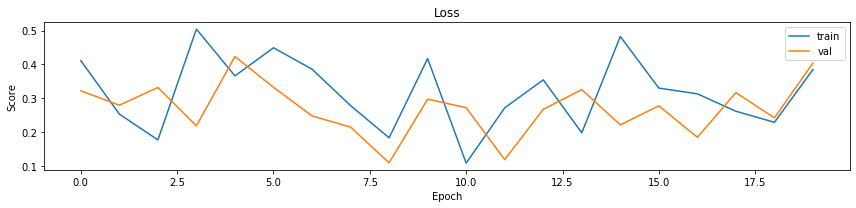

In [437]:
T.fit(20, 1e-9)

In [114]:
ls -lht data/models/v0

total 88
-rw-r--r--@ 1 hmamin  staff    27K Aug  6 23:14 history.png
-rw-r--r--  1 hmamin  staff   201B Aug  6 23:14 history.csv
-rw-r--r--  1 hmamin  staff   8.3K Aug  6 23:14 train.log


In [89]:
tdf = T.callbacks['MetricHistory'].df
tdf

,loss,val_loss
0,0.184578,0.075031
1,0.368238,0.079684
2,0.218755,0.056834
3,0.406346,0.085939
4,0.531336,0.054152
5,0.274740,0.066135
6,0.165185,0.151547
7,0.263990,0.187263
8,0.329825,0.073169
9,0.385534,0.107084
